# Input Data and Classification Model

### The Milky Way was so meh! Been there, done that!


Every group of document are separate by language and label. I am going to unify the languages to make three different models, one per language. So, the input must be in the same language and with the specific label.

In [3]:
# Imports
import pandas as pd
import numpy as np
import re
import glob, os

import spacy

import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [2]:
from spacy.lang.en.stop_words import STOP_WORDS
stopwords_en = list(STOP_WORDS)
from spacy.lang.fr.stop_words import STOP_WORDS
stopwords_fr = list(STOP_WORDS)
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_es = list(STOP_WORDS)

from spacy.lang.en import English
from spacy.lang.fr import French
from spacy.lang.es import Spanish


# 0. Preparing Data
In this part we are going to read the documents in the folders and join then in the same dataframe with the different labels for the training model. Because we are going to create 3 different models -one for each language- we are going to separate the dataframes because of the language.

In [3]:
def union_df(path, label):
    df_all = pd.DataFrame()
    for f in glob.glob(path + '/*.txt'):
        doc = [open(f, encoding='utf-8').read()]
        df = pd.DataFrame(doc, columns=['text'])
        df['label'] = label
        #df['file_name'] = re.findall('.+\/(.+\.txt)', f)
        #df = df[['label', 'text']]
        df_all = pd.concat([df_all,df], ignore_index = True)
    return df_all

In [4]:
label1 = 'APR'
label2 = 'Conference_papers'
label3 = 'PAN11'
label4 = 'Wikipedia'

# 1. English

### 1.1. Joing Dataframes

In [5]:
path1 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/APR/en'

path2 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/Conference_papers/en'

path3 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/PAN11/en'

path4 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/Wikipedia/en'


In [6]:
df_en1 = union_df(path1,label1)


In [7]:
df_en2 = union_df(path2,label2)


In [8]:
df_en3 = union_df(path3,label3)


In [9]:
df_en4 = union_df(path4,label4)

In [10]:
df_en = pd.concat([df_en1,df_en2, df_en3, df_en4], ignore_index = True)
df_en

,text,label
0,"i read this book because in my town, everyone ...",APR
1,recipes appreciated by the family (small and l...,APR
2,i say no to ease ..... and not to the author w...,APR
3,milady has found a good vein: anita blake. bas...,APR
4,"460 bc, somewhere in greece: ""gentlemen, i dec...",APR
...,...,...
9644,"Bupyeong-gu, Incheon. | location_country =...",Wikipedia
9645,Freedom Call is a German power metal band form...,Wikipedia
9646,majesty|consortname = Paola Ruffo di Calabriat...,Wikipedia
9647,Sertã (pron. ) is a municipality in Portugal ...,Wikipedia


I will be check few things about the new English dataframe:
- Lenght
- Columns
- Nulls

In [11]:
def checkingdf(df):
    length = len(df)
    columns = df.columns
    nulls = df.isnull().sum()
    return length, columns, nulls

In [12]:
checkingdf(df_en)

(9649,
 Index(['text', 'label'], dtype='object'),
 text     0
 label    0
 dtype: int64)

In [13]:
df_en.to_csv('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/training_data/english.csv', sep='\t', index=False)

Everything looks fine, or I should say... *Roger, Roger!*

### 1.2. Removing StopWords, Lemmanization, Tokenization and remove puntuation
Removing **stopwords** is an important step in NLP. It involves filtering out hihg-frecuency words that add little or no semantic value to a sentence.

**Lemmanization** is the act that convert the several infected forms of a word into a single form to make the analysis process easier. For example, if we have *I'am*, *you're* or *she wasn't* we will get the verb *to be* instead of the variations.

**Tokenization** is a technique where we divide the words into morphemes (basic unit of meaning).

Also, we are going to **remove puntuation** to reduce the content of the text files into words.

I am using SpaCy

In [14]:
lang = 'en'
nlp = spacy.load('en_core_web_md')

In [15]:
punctuations = string.punctuation
parser_en = English()
parser = parser_en

In [16]:
def spacy_tokenizer(sentence):
    #if lang == 'en':
     #   nlp = spacy.load(lang)
     #   tokens = English(sentence)
    #elif lang == 'fr':
     #   tokens == French(sentence)
    #elif lang == 'es':
     #   tokens == Spanish(sentence)
    #else:
     #   raise error
    tokens = parser(sentence)
    tokens = [w.lemma_.lower().strip() if w.lemma_ != '-PRON-!' else w.lower_ for w in tokens]
    tokens = [w for w in tokens if w not in stopwords_en and w not in punctuations]
    return tokens

### 1.3. ML with SKLearn

Custom transformer


In [17]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return[clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return[]

def clean_text(text):
    return text.strip().lower()

In [18]:
# Vectorization
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
classifier = LinearSVC()

# Using Tfidf
tfvectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)

I am going to split the dataframe. We areg going to need to select the right columns of the dataframe, but also, we want to keep some data out from training model to test it. I am going to do a 80 - 20.

In [19]:
# Features
X = df_en['text']

# Classification Labels
y = df_en['label']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [21]:
# Apply the pipeline to clean, tokenize, vectorize and classify
pipe = Pipeline([('cleaner', predictors()),('vectorizer', vectorizer), ('classifier', classifier)])

In [22]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x1a3220ac50>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x1a2616acb0>)),
                ('classifier', LinearSVC())])

In [23]:
sample_prediction = pipe.predict(X_test)

In [24]:

for(sample, pred) in zip(X_test,sample_prediction):
    print(f'Predict: {pred}')

Predict: APR
Predict: Wikipedia
Predict: APR
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Conference_papers
Predict: Wikipedia
Predict: APR
Predict: Wikipedia
Predict: APR
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: Wikipedia
Predict: Conference_papers
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: Wikipedia
Predict: APR
Predict: APR
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: APR
Predict: APR
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: PAN11
Predict: PAN11
Predict: APR
Predict: APR
Predict: APR
Predict: PAN11
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: Conference_papers
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: PAN11
Predict: Wikipedia

In [25]:
print(f'Accuracy test:{pipe.score(X_test, y_test)}')
print(f'Accuracy sample:{pipe.score(X_test, sample_prediction)}')

Accuracy test:0.9569948186528497
Accuracy sample:1.0


In [26]:
print(f'Accuracy score:{pipe.score(X_train, y_train)}')

Accuracy score:1.0


In [27]:
pipe.predict(['With a scientific method we can show the data in this graph. We want to show our investigation results of five years with machine learning models'])

array(['APR'], dtype=object)

In [28]:
pipe.predict(['I do not like this item at all'])

array(['APR'], dtype=object)

In [29]:
pipe.predict(['and the computer that ran the first public Bulletin Board Systems, CBBS]]A Bulletin Board System, or BBS, is a computer system running software that allows users to connect and login to the system using a terminal program. Originally BBSes were accessed only over a phone line using a modem, but by the early 1990s some BBSes allowed access via a Telnet or packet radio connection.Once a user logged in, they could perform functions such as downloading or uploading software and data, reading news, and exchanging messages with other users. Many BBSes also offered on-line games, in which users could compete with each other, and BBSes with multiple phone lines often offered IRC-like chat rooms, allowing users to meet each other.In recent years, the term BBS is sometimes incorrectly used to refer to any online forum or message board.During their heyday from the late 1970s to the mid 1990s, most BBSes were run as a hobby free of charge by the system operator (or "sysop"), while other BBSes charged their users a subscription fee for access, or were operated by a business as a means of supporting their customers. Bulletin Board Systems were in many ways a precursor to the modern form of the World Wide Web and other aspects of the Internet.Early BBSes were often a local phenomenon, as one had to dial into a BBS'])

array(['Wikipedia'], dtype=object)

In [30]:
pipe.predict(['A Long Island iced tea is a type of alcoholic mixed drink typically made with vodka, tequila, light rum, triple sec, gin, and a splash of cola, which gives the drink the same amber hue as its namesake.[1] A popular version mixes equal parts vodka, tequila, gin, rum, triple sec, with ​1 1⁄2 parts sour mix and a splash of cola. Lastly, it is decorated with the lemon and straw, after stirring with bar spoon smoothly.[2]Most variants use equal parts of the main liquors, but include a smaller amount of triple sec (or other orange-flavored liqueur). Close variants often replace the sour mix with lemon juice, replace the cola with diet cola or actual iced tea, or add white crème de menthe. Most variants do not include any tea.The drink has a much higher alcohol concentration (approximately 22 percent) than most highball drinks due to the relatively small amount of mixer.'])

array(['APR'], dtype=object)

# 2. French

In [31]:
path1 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/APR/fr'

path2 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/Conference_papers/fr'

path4 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/Wikipedia/fr'

In [32]:
df_fr1 = union_df(path1,label1)
df_fr2 = union_df(path2,label2)
df_fr4 = union_df(path4,label4)
df_fr = pd.concat([df_fr1, df_fr2, df_fr4], ignore_index = True)
df_fr

,text,label
0,"J'avais beaucoup aimé les premiers albums du ""...",APR
1,Je me joins aux commentaires peu satisfaits......,APR
2,"À sa parution en 1979, ce livre n'a pas rencon...",APR
3,Je découvre Douglas Kennedy et j'aimerais que ...,APR
4,J'ai acheté ce livre à la lecture des commenta...,APR
...,...,...
7958,", Nuremberg |années actives = depuis 1998 |gen...",Wikipedia
7959,Une cellule polyploïde (du grec : πολλαπλόν - ...,Wikipedia
7960,", George W. Bush et Albert II le .]]La reine ...",Wikipedia
7961,Sertã est une petite ville portugaise de 5 50...,Wikipedia


In [33]:
checkingdf(df_fr)

(7963,
 Index(['text', 'label'], dtype='object'),
 text     0
 label    0
 dtype: int64)

In [34]:
df_fr.to_csv('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/training_data/french.csv', header= False, index=False)

In [35]:
lang = 'fr'
nlp = spacy.load('fr_core_news_lg')
parser_fr = French()
parser = parser_fr
# Vectorization
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
classifier = LinearSVC()

# Using Tfidf
tfvectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)

# Features
X = df_fr['text']

# Classification Labels
y = df_fr['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Apply the pipeline to clean, tokenize, vectorize and classify
pipe = Pipeline([('cleaner', predictors()),('vectorizer', vectorizer), ('classifier', classifier)])

pipe.fit(X_train,y_train)

sample_prediction = pipe.predict(X_test)

/Users/Natalio/miniconda3/envs/ea_env/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [36]:

for(sample, pred) in zip(X_test,sample_prediction):
    print(f'Predict: {pred}')
print(f'Accuracy test:{pipe.score(X_test, y_test)}')
print(f'Accuracy sample:{pipe.score(X_test, sample_prediction)}')

Predict: APR
Predict: APR
Predict: Wikipedia
Predict: APR
Predict: Wikipedia
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: APR
Predict: APR
Predict: APR
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: APR
Predict: APR
Predict: APR
Predict: Wikipedia
Predict: APR
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Conference_papers
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: APR
Predict: APR
Predict: APR
Predict: W

Accuracy test:0.9943502824858758
Accuracy sample:1.0


In [37]:
pipe.predict(["Le Long Island iced tea ou LIIT ou Long Island littéralement thé glacé Long Island en anglais est un cocktail à base de tequila gin vodka rhum liqueur doranges et cola Ce cocktail officiel de lIBA tient son nom de sa ressemblance à du thé glacé bien quil nen contienne pas)"])

array(['APR'], dtype=object)

# 3. Spanish

In [38]:
path3 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/PAN11/es'

path4 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/Wikipedia/es'

In [39]:
df_es3 = union_df(path3,label3)
df_es4 = union_df(path4,label4)
df_es = pd.concat([df_es3, df_es4], ignore_index = True)
df_es

,text,label
0,"El primero dia pafamos aquellas Lagunas, i pa...",PAN11
1,"A la puesta del Sol, por vnos llanos, i entre...",PAN11
2,"\n\nLa Tierra, por la maior parte, defde donde...",PAN11
3,\n\nCAP. XXXVI. De como hecimos hacer Iglesias...,PAN11
4,¡Asombra el imaginar lo que hubiera dado este...,PAN11
...,...,...
4992,| fecha_de_fallecimiento = 8 de enero de 1981|...,Wikipedia
4993,Red Hat es la compañía responsable de la creac...,Wikipedia
4994,Bashkortostán (en ruso: Республика Башкортоста...,Wikipedia
4995,|zona=Polinesia |hablantes=165.000 (censo 200...,Wikipedia


In [40]:
checkingdf(df_es)

(4997,
 Index(['text', 'label'], dtype='object'),
 text     0
 label    0
 dtype: int64)

In [41]:
df_es.to_csv('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/training_data/spanish.csv', header= False, index=False)

In [42]:
lang = 'es'
nlp = spacy.load('es_core_news_lg')
parser_en = Spanish()
parser = parser_en
# Vectorization
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
classifier = LinearSVC()

# Using Tfidf
tfvectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)

# Features
X = df_es['text']

# Classification Labels
y = df_es['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Apply the pipeline to clean, tokenize, vectorize and classify
pipe = Pipeline([('cleaner', predictors()),('vectorizer', vectorizer), ('classifier', classifier)])

pipe.fit(X_train,y_train)

sample_prediction = pipe.predict(X_test)

In [43]:
for(sample, pred) in zip(X_test,sample_prediction):
    print(f'Predict: {pred}')
print(f'Accuracy test:{pipe.score(X_test, y_test)}')
print(f'Accuracy sample:{pipe.score(X_test, sample_prediction)}')

Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: PAN11
Predict: PAN11
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: PAN11
Predict: Wikipedia
Predict: Wikipedia
Predict: Wikipedia

Accuracy test:0.998
Accuracy sample:1.0


In [44]:
pipe.predict(['Un Té Helado Long Island es un tipo de bebida alcohólica mezclada hecha típicamente con, entre otros,vodka, ron blanco, triple seco, y ginebra.1​ Se llama así debido a su parecido con el color y el sabor del Té helado (Camellia sinensis). Una versión popular mezcla partes iguales de vodka, ginebra,ron, y triple seco con 1½ partes de sour mix y un toque de refresco de cola, lo cual le da a la bebida el mismo color ámbar de su fundador. La mayoría de las variantes usan partes iguales de los licores principales, pero incluye una parte pequeña de triple seco (u otro licor sabor naranja). Variantes cercanas reemplazan seguido el sour mix con jugo de limón, el refresco de cola con uno de cola de dieta o té helado, o agregan crema de menta; sin embargo, la mayoría de las variantes no incluyen té. Algunos restaurantes substituyen brandy por el tequila. Algunas variantes de la bebida tienen nombres alternativos como lo son Texas Iced Tea, Georgia Iced Tea, Tokyo Tea, Three Mile Island, y Adios Mother Fucker. La bebida tiene una más alta concentración de alcohol (aproximadamente 22 por ciento) que la mayoría de los cocteles debido a la relativamente pequeña porción de soda. El Long Island puede ser ordenado extra largo, con un mayor incremento de alcohol en la mezcla.'])

array(['PAN11'], dtype=object)

## 4. Conclusions
Model have a good ratio, but the model is overfit to APR label in all languages. It will be necessary to come back and keep cleaning data for a better result.


## 5. Next steps
With the objetive of improve the model it will be interesting to try:
- Balance the dataset. Equitative number from different labels
- Join the model with the function of language detection. With this step first we will check the language of the text and after the text come into the right model
- Check numbers in input data

# Topic Modeling

## Get ready; today is not gonna be easy

The objetive 2 of the test ask for a topic modeling. We are going to work to find the topics that are present in the different files.

In [11]:
# Imports

import pandas as pd
import os, glob
import re
import string
import pickle
import numpy as np


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from gensim import matutils, models
import scipy.sparse

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/Natalio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Natalio/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
pd.set_option('max_colwidth',150)

### 1. Data preparation for Topic Modeling

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

With text data, this cleaning process can go on forever. There's always an exception to every cleaning step. So, we're going to follow the MVP (minimum viable product) approach - start simple and iterate. Here are a bunch of things you can do to clean your data. We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

In [13]:
def create_dic(path, label):
    doc_all = []
    for f in glob.glob(path + '/*.txt'):
        doc = [open(f, encoding='utf-8').read()]
        doc_all.append(doc)
    combined_text = ' '.join([str(elem) for elem in doc_all])
    combined_text = combined_text.lower()
    dic = {label:combined_text}
    return dic

In [14]:
path1 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/APR/en'
path2 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/Conference_papers/en'
path3 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/PAN11/en'
path4 = '/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/documents_challenge/Wikipedia/en'

pathen = [path1, path2, path3, path4]

In [15]:
def combine_dic(paths):
    combined_dic = {}
    for i in paths:
        label = str(re.findall('.+\/(.+?)\/en',str(i)))
        dic = create_dic(i, label)
        combined_dic.update(dic)
    return combined_dic

In [16]:
a = combine_dic(pathen)

In [17]:
data_df = pd.DataFrame.from_dict(a, orient ='index')
data_df.columns = ['text']
data_df = data_df.sort_index()
data_df

,text
['APR'],"[""i read this book because in my town, everyone uses it and order. this is my pharmacist who advised me she was so thin i asked her what she had d..."
['Conference_papers'],"['abstract in this paper, we propose a method for summarizing olap query logs. the basic idea is that\n a query summarizes another query and that ..."
['PAN11'],"[' \n\n""well, better that it happened all that has happened. god have mercy on me and forgive my sins.\ni know it is about time that god called me..."
['Wikipedia'],"["" |timezone=eet |utc_offset=+2 |timezone_dst=eest |utc_offset_dst=+3 |map_caption = location of baia mare| | official_name=baia mare| image_skyli..."


In [18]:
def clean_text_round(text):
# Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

clean_text = lambda x: clean_text_round(x)

In [19]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_df.text.apply(clean_text))
data_clean

,text
['APR'],is we know entirely surrounded by the sea except from side where it affects asia and the king of egypt nécôs are the first to our knowledge g...
['Conference_papers'],as a clear evidence of this it has recentlyn been shown that browsing and querying logs actually speeds up the query formulationn by supporting ...
['PAN11'],nnnncharles i had more than six hundred paintings known his power itnis easy to deduce the treasures that ac...
['Wikipedia'],liberal democratic union of hungarians in romania the bronze age the region around baia mare was the realm of the thracians from whom the get...


### 2. Organizing The Data

Organized data in two standard text formats:
1. **Corpus - **a collection of text
2. **Document-Term Matrix - **word counts in matrix format

### 2.1. Corpus

In [20]:
data_df
labels = ['APR', 'Conference_papers', 'PAN11', 'Wikipedia']

data_df['label'] = labels
data_df

,text,label
['APR'],"[""i read this book because in my town, everyone uses it and order. this is my pharmacist who advised me she was so thin i asked her what she had d...",APR
['Conference_papers'],"['abstract in this paper, we propose a method for summarizing olap query logs. the basic idea is that\n a query summarizes another query and that ...",Conference_papers
['PAN11'],"[' \n\n""well, better that it happened all that has happened. god have mercy on me and forgive my sins.\ni know it is about time that god called me...",PAN11
['Wikipedia'],"["" |timezone=eet |utc_offset=+2 |timezone_dst=eest |utc_offset_dst=+3 |map_caption = location of baia mare| | official_name=baia mare| image_skyli...",Wikipedia


In [21]:
data_df.to_pickle('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/corpus.pkl')

### 2.2. Document-Term Matrix

For many of the techniques we'll be using, the text must be tokenized, meaning broken down into smaller pieces. The most common tokenization technique is to break down text into words. We can do this using scikit-learn's CountVectorizer, where every row will represent a different document and every column will represent a different word.

In addition, with CountVectorizer, we can remove stop words. Stop words are common words that add no additional meaning to text such as 'a', 'the', etc.

In [22]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,aa,aaa,aaaconsejo,aaai,aaba,aabb,aabba,aabn,aac,aachen,...,호퍼,호프먼,홀로,회로,회의,횡단,횡단도로,효과,히틀러,ﺧﯘﺑﺎﻧﯽin
['APR'],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
['Conference_papers'],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
['PAN11'],8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
['Wikipedia'],31,13,1,1,1,1,1,1,3,13,...,1,1,1,1,1,1,1,1,1,1


In [23]:
# Let's pickle it for later use
data_dtm.to_pickle('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/dtm.pkl')
# Let's also pickle the cleaned data (before we put it in document-term matrix format) and the CountVectorizer object
data_clean.to_pickle('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/data_clean.pkl')
pickle.dump(cv, open('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/cv.pkl', 'wb'))

### 3. Exploratory Data Analysis


After the data cleaning step where we put our data into a few standard formats, the next step is to take a look at the data and see if what we're looking at makes sense. Before applying any fancy algorithms, it's always important to explore the data first.

When working with numerical data, some of the exploratory data analysis (EDA) techniques we can use include finding the average of the data set, the distribution of the data, the most common values, etc. The idea is the same when working with text data. We are going to find some more obvious patterns with EDA before identifying the hidden patterns with machines learning (ML) techniques.

1. **Most common words:**  find these and create word clouds
2. **Size of vocabulary:**  look number of unique words and also how quickly someone speaks
3. **Amount of profanity:**  most common terms

In [24]:
data = pd.read_pickle('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/dtm.pkl')
data = data.transpose()
data.head()

,['APR'],['Conference_papers'],['PAN11'],['Wikipedia']
aa,0,0,8,31
aaa,0,0,0,13
aaaconsejo,0,0,0,1
aaai,0,0,0,1
aaba,0,0,0,1


In [25]:
# Find the top 30 words
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{"['APR']": [('little', 6),
  ('book', 4),
  ('walk', 4),
  ('sea', 4),
  ('jesus', 4),
  ('books', 3),
  ('youll', 3),
  ('use', 3),
  ('egypt', 3),
  ('amp', 3),
  ('sb', 3),
  ('volume', 3),
  ('come', 3),
  ('faith', 3),
  ('guests', 2),
  ('marching', 2),
  ('love', 2),
  ('comments', 2),
  ('church', 2),
  ('world', 2),
  ('great', 2),
  ('growth', 2),
  ('sound', 2),
  ('history', 2),
  ('phoenicians', 2),
  ('harvest', 2),
  ('knowledge', 2),
  ('christianity', 2),
  ('warming', 2),
  ('taken', 2)],
 "['Conference_papers']": [('rule', 9),
  ('query', 8),
  ('attributes', 8),
  ('relations', 8),
  ('vectors', 7),
  ('set', 7),
  ('concepts', 7),
  ('authors', 7),
  ('values', 7),
  ('measure', 7),
  ('used', 7),
  ('model', 7),
  ('andn', 7),
  ('use', 7),
  ('number', 7),
  ('rules', 6),
  ('using', 6),
  ('terms', 6),
  ('dialogue', 6),
  ('frequency', 6),
  ('feature', 6),
  ('algorithms', 5),
  ('graph', 5),
  ('define', 5),
  ('framework', 5),
  ('size', 5),
  ('value', 5),

In [26]:
# Print the top 15 words
for i, top_words in top_dict.items():
    print(i)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

['APR']
little, book, walk, sea, jesus, books, youll, use, egypt, amp, sb, volume, come, faith
---
['Conference_papers']
rule, query, attributes, relations, vectors, set, concepts, authors, values, measure, used, model, andn, use
---
['PAN11']
people, inca, great, said, time, city, say, know, extension, way, did, cuzco, came, good
---
['Wikipedia']
new, used, city, world, time, years, war, known, use, called, number, united, later, including
---


At this point, we could add few words with very little meaning to the stop words but we are going to continue and create word clouds.

Found "say" and "said". Lemmanization is a good option for further steps.

In [27]:
stop_words = text.ENGLISH_STOP_WORDS
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

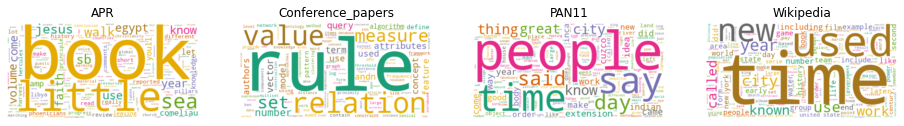

In [28]:
plt.rcParams['figure.figsize'] = [16, 6]


# Create subplots for each label
for index, l in enumerate(data.columns):
    wc.generate(data_clean.text[l])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(labels[index])
    
plt.show()

### Findings

We can determine that the most common words of every labels are:


- **APR:**  Book, Little, Sea
- **Conference papers:**  Rule, relation, value, set, measure
- **PAN11:**  People, time, say
- **Wikipedia:**  Time, new, used, city

Few words are in common in the different labels, like "year", "use", "work" or "city".

### 4. Number of Words


### 4.1. Analysis

In [29]:
# Find the number of unique words that each label uses

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for w in data.columns:
    uniques = data[w].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(labels, unique_list)), columns=['label', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort

,label,unique_words
0,APR,481
1,Conference_papers,984
2,PAN11,34525
3,Wikipedia,332095


_Unbalanced dataset strickes back_

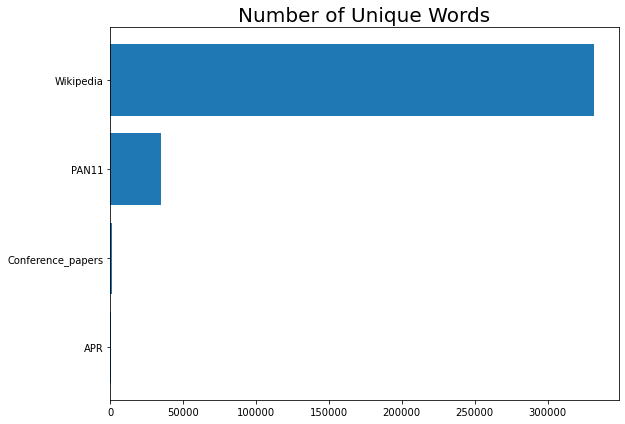

In [30]:
# Let's plot our findings


y_pos = np.arange(len(data_words))

plt.subplot(1, 2, 1)
plt.barh(y_pos, data_unique_sort.unique_words, align='center')
plt.yticks(y_pos, data_unique_sort.label)
plt.title('Number of Unique Words', fontsize=20)


plt.tight_layout()
plt.show()

### 4.2. Findings
* **Vocabulary**
   * Wikipedia use a lot of different words in the documents we analize.
   * APR has a smaller vocabulary even when we have 3585 files

In [31]:
# Let's isolate just the graph more visible words
data_words = data.transpose()[['year', 'use']]
data_words2 = pd.concat([data_words.year, data_words.use], axis=1)
data_words2.columns = ['year', 'use']
data_words2

,year,use
['APR'],1,3
['Conference_papers'],0,7
['PAN11'],156,79
['Wikipedia'],2556,3165


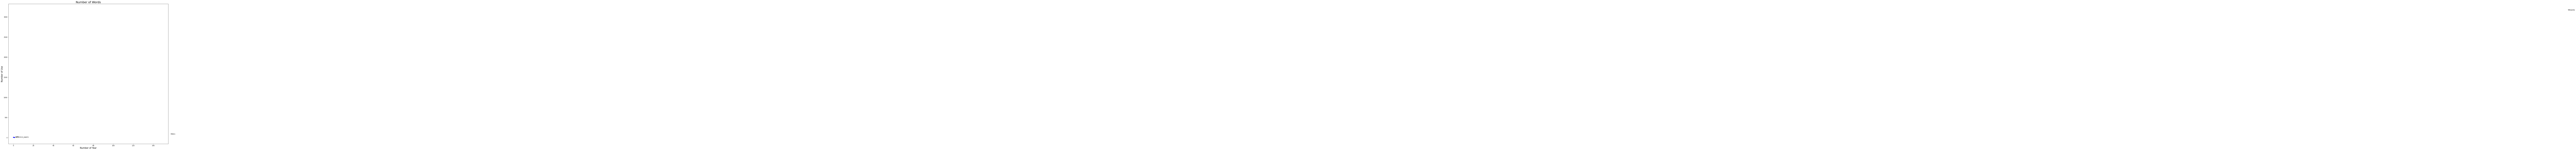

In [32]:
# Let's create a scatter plot of our findings
plt.rcParams['figure.figsize'] = [20, 18]

for i, w in enumerate(data_words2.index):
    x = data_words2.year.loc[w]
    y = data_words2.use.loc[w]
    plt.scatter(x, y, color='blue')
    plt.text(x+1.5, y+0.5, labels[i], fontsize=10)
    plt.xlim(-5, 155) 
    
plt.title('Number of Words', fontsize=20)
plt.xlabel('Number of Year', fontsize=15)
plt.ylabel('Number of Use', fontsize=15)

plt.show()

### 5. Sentiment Analysis

When it comes to text data, there are a few popular techniques, starting with sentiment analysis. A few key points to remember with sentiment analysis.

TextBlob Module: Linguistic researchers have labeled the sentiment of words based on their domain expertise. Sentiment of words can vary based on where it is in a sentence. The TextBlob module allows us to take advantage of these labels.
Sentiment Labels: Each word in a corpus is labeled in terms of polarity and subjectivity (there are more labels as well, but we're going to ignore them for now). A corpus' sentiment is the average of these.

Polarity: How positive or negative a word is. -1 is very negative. +1 is very positive.

Subjectivity: How subjective, or opinionated a word is. 0 is fact. +1 is very much an opinion.

In [33]:
data = pd.read_pickle('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/corpus.pkl')

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['polarity'] = data['text'].apply(pol)
data['subjectivity'] = data['text'].apply(sub)
data

,text,label,polarity,subjectivity
['APR'],"[""i read this book because in my town, everyone uses it and order. this is my pharmacist who advised me she was so thin i asked her what she had d...",APR,0.135201,0.528060
['Conference_papers'],"['abstract in this paper, we propose a method for summarizing olap query logs. the basic idea is that\n a query summarizes another query and that ...",Conference_papers,0.076210,0.415196
['PAN11'],"[' \n\n""well, better that it happened all that has happened. god have mercy on me and forgive my sins.\ni know it is about time that god called me...",PAN11,0.095309,0.495447
['Wikipedia'],"["" |timezone=eet |utc_offset=+2 |timezone_dst=eest |utc_offset_dst=+3 |map_caption = location of baia mare| | official_name=baia mare| image_skyli...",Wikipedia,0.087155,0.384622


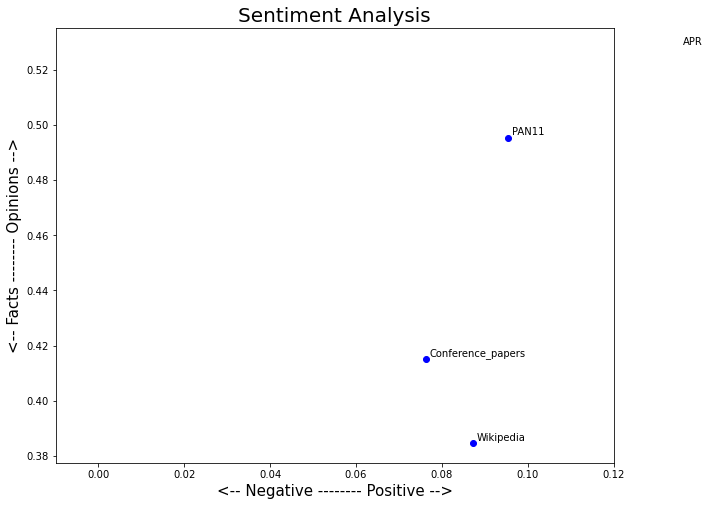

In [34]:
# Let's plot the results

plt.rcParams['figure.figsize'] = [10, 8]

for index, w in enumerate(data.index):
    x = data.polarity.loc[w]
    y = data.subjectivity.loc[w]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, data['label'][index], fontsize=10)
    plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

### 5.1. Findings

- **Facts & Opinions:**  It is looks like Wikipedia and Conference papers talks about facts and PAN11 and APR talks about opinions. It is makes sense with the information about the text we know

The ultimate goal of topic modeling is to find various topics that are present in our corpus. Each document in the corpus will be made up of at least one topic, if not multiple topics.

We will be covering the steps on how to do **Latent Dirichlet Allocation (LDA)**, which is one of many topic modeling techniques. It was specifically designed for text data.

To use a topic modeling technique, you need to provide (1) a document-term matrix and (2) the number of topics you would like the algorithm to pick up.

### 6. Topic Modeling - Attempt #1 (All Text)

In [35]:
data = pd.read_pickle('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/dtm.pkl')
tdm = data.transpose()
tdm.head()

,['APR'],['Conference_papers'],['PAN11'],['Wikipedia']
aa,0,0,8,31
aaa,0,0,0,13
aaaconsejo,0,0,0,1
aaai,0,0,0,1
aaba,0,0,0,1


In [36]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [37]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/cv.pkl', 'rb'))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [38]:
# We need to specify two other parameters as well - the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.002*"people" + 0.002*"inca" + 0.002*"great" + 0.001*"said" + 0.001*"time" + 0.001*"city" + 0.001*"say" + 0.001*"know" + 0.001*"extension" + 0.001*"did"'),
 (1,
  '0.003*"new" + 0.002*"used" + 0.002*"city" + 0.002*"world" + 0.002*"time" + 0.001*"years" + 0.001*"war" + 0.001*"known" + 0.001*"use" + 0.001*"called"')]

In [39]:
# LDA for num_topics = 3
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.002*"people" + 0.002*"inca" + 0.002*"great" + 0.002*"said" + 0.002*"time" + 0.002*"city" + 0.001*"say" + 0.001*"know" + 0.001*"extension" + 0.001*"did"'),
 (1,
  '0.003*"new" + 0.002*"used" + 0.002*"city" + 0.002*"world" + 0.002*"time" + 0.001*"years" + 0.001*"war" + 0.001*"known" + 0.001*"use" + 0.001*"called"'),
 (2,
  '0.001*"new" + 0.001*"city" + 0.001*"used" + 0.001*"time" + 0.001*"world" + 0.001*"use" + 0.001*"war" + 0.001*"number" + 0.000*"known" + 0.000*"later"')]

In [40]:
# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.003*"new" + 0.002*"used" + 0.002*"city" + 0.002*"world" + 0.002*"time" + 0.002*"years" + 0.001*"war" + 0.001*"known" + 0.001*"use" + 0.001*"called"'),
 (1,
  '0.000*"new" + 0.000*"used" + 0.000*"city" + 0.000*"world" + 0.000*"war" + 0.000*"number" + 0.000*"known" + 0.000*"called" + 0.000*"state" + 0.000*"years"'),
 (2,
  '0.001*"used" + 0.001*"new" + 0.000*"city" + 0.000*"war" + 0.000*"years" + 0.000*"time" + 0.000*"use" + 0.000*"known" + 0.000*"number" + 0.000*"world"'),
 (3,
  '0.002*"people" + 0.002*"inca" + 0.002*"great" + 0.002*"said" + 0.002*"time" + 0.002*"city" + 0.002*"say" + 0.001*"know" + 0.001*"extension" + 0.001*"did"')]

In [41]:
# LDA for num_topics = 1
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=1, passes=10)
lda.print_topics()

[(0,
  '0.003*"new" + 0.002*"used" + 0.002*"city" + 0.002*"time" + 0.002*"world" + 0.001*"years" + 0.001*"war" + 0.001*"known" + 0.001*"people" + 0.001*"called"')]

### 7. Topic Modeling - Attempt #2 (Nouns Only)

In [42]:
def nouns(text):
    # Given a string of text, tokenize the text and pull out only the nouns
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [43]:
data_clean = pd.read_pickle('/Users/Natalio/Desktop/nlp_associate_ds_test/NLP_Associate_DS_Test/data/data_clean.pkl')
data_clean

,text
['APR'],is we know entirely surrounded by the sea except from side where it affects asia and the king of egypt nécôs are the first to our knowledge g...
['Conference_papers'],as a clear evidence of this it has recentlyn been shown that browsing and querying logs actually speeds up the query formulationn by supporting ...
['PAN11'],nnnncharles i had more than six hundred paintings known his power itnis easy to deduce the treasures that ac...
['Wikipedia'],liberal democratic union of hungarians in romania the bronze age the region around baia mare was the realm of the thracians from whom the get...


In [44]:
data_nouns = pd.DataFrame(data_clean.text.apply(nouns))
data_nouns

,text
['APR'],sea side asia king nécôs knowledge evidence canal nile gulf vessels phoenicians orders pillars hercules sea sea eritrea phoenicians sea autumn coa...
['Conference_papers'],evidence browsing logs query formulationn query reuse n context instance recommendationsn knowledge problem end user concise representation logn d...
['PAN11'],nnnncharles paintings power itnis treasures palaces netherlands spain aunt dona ofnaustria paintings inof france henry viii england wealthnnbut tr...
['Wikipedia'],union hungarians romania bronze age region baia mare realm thracians getodacians part state burebista mention settlement géza ii hungary saxons na...


In [45]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpus, num_topics=2, id2word=id2word, passes=10)
ldan.print_topics()

[(0,
  '0.002*"people" + 0.002*"inca" + 0.002*"great" + 0.001*"said" + 0.001*"time" + 0.001*"city" + 0.001*"say" + 0.001*"know" + 0.001*"extension" + 0.001*"way"'),
 (1,
  '0.003*"new" + 0.002*"used" + 0.002*"city" + 0.002*"world" + 0.002*"time" + 0.001*"years" + 0.001*"war" + 0.001*"known" + 0.001*"use" + 0.001*"called"')]

In [46]:
# Let's try topics = 3
ldan = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=10)
ldan.print_topics()

[(0,
  '0.002*"people" + 0.002*"inca" + 0.002*"great" + 0.002*"said" + 0.002*"time" + 0.002*"city" + 0.001*"say" + 0.001*"know" + 0.001*"extension" + 0.001*"did"'),
 (1,
  '0.000*"new" + 0.000*"used" + 0.000*"known" + 0.000*"time" + 0.000*"city" + 0.000*"use" + 0.000*"including" + 0.000*"world" + 0.000*"united" + 0.000*"war"'),
 (2,
  '0.003*"new" + 0.002*"used" + 0.002*"city" + 0.002*"world" + 0.002*"time" + 0.001*"years" + 0.001*"war" + 0.001*"known" + 0.001*"use" + 0.001*"called"')]

In [47]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpus, num_topics=4, id2word=id2word, passes=10)
ldan.print_topics()

[(0,
  '0.000*"new" + 0.000*"time" + 0.000*"city" + 0.000*"used" + 0.000*"number" + 0.000*"called" + 0.000*"later" + 0.000*"years" + 0.000*"known" + 0.000*"use"'),
 (1,
  '0.000*"new" + 0.000*"used" + 0.000*"city" + 0.000*"time" + 0.000*"world" + 0.000*"known" + 0.000*"years" + 0.000*"use" + 0.000*"century" + 0.000*"isbn"'),
 (2,
  '0.003*"new" + 0.002*"used" + 0.002*"city" + 0.002*"world" + 0.002*"time" + 0.002*"years" + 0.001*"war" + 0.001*"known" + 0.001*"use" + 0.001*"called"'),
 (3,
  '0.002*"people" + 0.002*"great" + 0.002*"inca" + 0.002*"time" + 0.002*"said" + 0.002*"city" + 0.002*"say" + 0.001*"know" + 0.001*"extension" + 0.001*"did"')]

In [48]:
ldan = models.LdaModel(corpus=corpus, num_topics=1, id2word=id2word, passes=10)
ldan.print_topics()

[(0,
  '0.003*"new" + 0.002*"used" + 0.002*"city" + 0.002*"time" + 0.002*"world" + 0.001*"years" + 0.001*"war" + 0.001*"known" + 0.001*"people" + 0.001*"called"')]

In [51]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [53]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(data_clean.text.apply(nouns_adj))
data_nouns_adj

,text
['APR'],sea side asia king egypt nécôs first knowledge evidence canal nile arabian gulf vessels phoenicians orders pillars hercules northern sea sea eritr...
['Conference_papers'],clear evidence browsing logs query formulationn better query reuse n relevant collaborative context instance recommendationsn best knowledge simpl...
['PAN11'],nnnncharles hundred paintings power itnis easy treasures palaces netherlands italy spain aunt dona ofnaustria more hundred paintings francis inof ...
['Wikipedia'],liberal democratic union hungarians romania bronze age region baia mare realm thracians getodacians part large dacian state burebista first mentio...


In [54]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.text)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

,aa,aaa,aaaconsejo,aaai,aaba,aabb,aabba,aabn,aac,aachen,...,호노리오,호퍼,호프먼,홀로,회로,회의,횡단,횡단도로,히틀러,ﺧﯘﺑﺎﻧﯽin
['APR'],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
['Conference_papers'],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
['PAN11'],5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
['Wikipedia'],25,12,1,1,1,1,1,1,1,11,...,1,1,1,1,1,1,1,1,1,1


In [55]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [56]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.002*"people" + 0.002*"great" + 0.002*"inca" + 0.002*"city" + 0.001*"extension" + 0.001*"large" + 0.001*"body" + 0.001*"cuzco" + 0.001*"day" + 0.001*"order"'),
 (1,
  '0.003*"city" + 0.002*"world" + 0.002*"years" + 0.002*"war" + 0.002*"number" + 0.002*"people" + 0.001*"national" + 0.001*"university" + 0.001*"century" + 0.001*"united"')]

In [57]:
# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.003*"people" + 0.003*"great" + 0.002*"inca" + 0.002*"city" + 0.002*"extension" + 0.001*"body" + 0.001*"cuzco" + 0.001*"large" + 0.001*"day" + 0.001*"idea"'),
 (1,
  '0.000*"city" + 0.000*"world" + 0.000*"people" + 0.000*"war" + 0.000*"national" + 0.000*"history" + 0.000*"year" + 0.000*"university" + 0.000*"years" + 0.000*"states"'),
 (2,
  '0.003*"city" + 0.003*"world" + 0.002*"years" + 0.002*"war" + 0.002*"number" + 0.002*"people" + 0.002*"national" + 0.002*"university" + 0.001*"united" + 0.001*"century"')]

In [58]:
# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.000*"city" + 0.000*"world" + 0.000*"war" + 0.000*"years" + 0.000*"university" + 0.000*"number" + 0.000*"united" + 0.000*"century" + 0.000*"film" + 0.000*"states"'),
 (1,
  '0.003*"people" + 0.003*"great" + 0.003*"inca" + 0.002*"city" + 0.002*"extension" + 0.002*"body" + 0.002*"cuzco" + 0.002*"large" + 0.001*"day" + 0.001*"idea"'),
 (2,
  '0.000*"city" + 0.000*"world" + 0.000*"years" + 0.000*"number" + 0.000*"people" + 0.000*"united" + 0.000*"war" + 0.000*"year" + 0.000*"national" + 0.000*"states"'),
 (3,
  '0.003*"city" + 0.003*"world" + 0.002*"years" + 0.002*"war" + 0.002*"number" + 0.002*"people" + 0.002*"national" + 0.002*"university" + 0.002*"united" + 0.002*"century"')]

In [59]:
# Our final LDA model (for now)
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=80)
ldana.print_topics()

[(0,
  '0.003*"city" + 0.003*"world" + 0.002*"years" + 0.002*"war" + 0.002*"number" + 0.002*"people" + 0.002*"national" + 0.002*"university" + 0.002*"united" + 0.002*"century"'),
 (1,
  '0.003*"people" + 0.003*"great" + 0.003*"inca" + 0.002*"city" + 0.002*"extension" + 0.002*"cuzco" + 0.002*"body" + 0.002*"large" + 0.001*"things" + 0.001*"idea"'),
 (2,
  '0.000*"query" + 0.000*"ontology" + 0.000*"wordnet" + 0.000*"synsets" + 0.000*"multisets" + 0.000*"ofn" + 0.000*"andn" + 0.000*"modularity" + 0.000*"wen" + 0.000*"lexical"'),
 (3,
  '0.000*"world" + 0.000*"city" + 0.000*"years" + 0.000*"people" + 0.000*"war" + 0.000*"number" + 0.000*"american" + 0.000*"century" + 0.000*"national" + 0.000*"united"')]

In [64]:
# Let's take a look at which topics each transcript contains
corpus_transformed = ldana[corpusna]
#list(zip([a for [(a,b)] in corpus_transformed], data_dtmna.index))